# Hands-on Exercise (4)

**Quantum Machine Learning Applications to High-Energy Physics**

## Event Classfication using Quantum Neural Networks

First, we consider the problem of classifying signal events from background events using kinematic features in the events, one of the most representative tasks for machine learning in HEP data analysis.

### Preparation of training data

In [1]:
%pip install qiskit-algorithms qiskit-optimization qiskit-machine-learning

# Tested with python 3.10.11, qiskit 0.42.1, numpy 1.23.5, scipy 1.9.3
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from collections import OrderedDict

from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import TwoLocal, ZFeatureMap, ZZFeatureMap
from qiskit.primitives import Estimator, Sampler, BackendEstimator
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
from qiskit_algorithms.minimum_eigensolvers import VQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA, COBYLA
from qiskit_optimization.applications import OptimizationApplication
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler as RuntimeSampler
from qiskit_ibm_runtime.accounts import AccountNotFoundError
from qiskit_aer import AerSimulator
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.kernels import FidelityQuantumKernel

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Read data from file
df = pd.read_csv("data/SUSY_1K.csv",
                 names=('isSignal','lep1_pt','lep1_eta','lep1_phi','lep2_pt','lep2_eta',
                        'lep2_phi','miss_ene','miss_phi','MET_rel','axial_MET','M_R','M_TR_2',
                        'R','MT2','S_R','M_Delta_R','dPhi_r_b','cos_theta_r1'))

# Number of input features for training
feature_dim = 3

# Feature variables
if feature_dim == 3:
    selected_features = ['lep1_pt', 'lep2_pt', 'miss_ene']
elif feature_dim == 5:
    selected_features = ['lep1_pt','lep2_pt','miss_ene','M_TR_2','M_Delta_R']
elif feature_dim == 7:
    selected_features = ['lep1_pt','lep1_eta','lep2_pt','lep2_eta','miss_ene','M_TR_2','M_Delta_R']

# Number of events used in the training and testing
train_size = 20
test_size = 20

df_sig = df.loc[df.isSignal==1, selected_features]
df_bkg = df.loc[df.isSignal==0, selected_features]

# Extract the samples
df_sig_train = df_sig.values[:train_size]
df_bkg_train = df_bkg.values[:train_size]
df_sig_test = df_sig.values[train_size:train_size + test_size]
df_bkg_test = df_bkg.values[train_size:train_size + test_size]
# The first train_size events contain SUSY signal and the last train_size events do not.
train_data = np.concatenate([df_sig_train, df_bkg_train])
# The first test_size events contain SUSY signal and the last test_size events do not.
test_data = np.concatenate([df_sig_test, df_bkg_test])

# Label
train_label = np.zeros(train_size * 2, dtype=int)
train_label[:train_size] = 1
test_label = np.zeros(train_size * 2, dtype=int)
test_label[:test_size] = 1

train_label_one_hot = np.zeros((train_size * 2, 2))
train_label_one_hot[:train_size, 0] = 1
train_label_one_hot[train_size:, 1] = 1
test_label_one_hot = np.zeros((test_size * 2, 2))
test_label_one_hot[:test_size, 0] = 1
test_label_one_hot[test_size:, 1] = 1

#datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)
#datapoints_tr, class_to_label_tr = split_dataset_to_data_and_labels(training_input)

mms = MinMaxScaler((-1, 1))
norm_train_data = mms.fit_transform(train_data)
norm_test_data = mms.transform(test_data)

### State Preparation with Feature Map

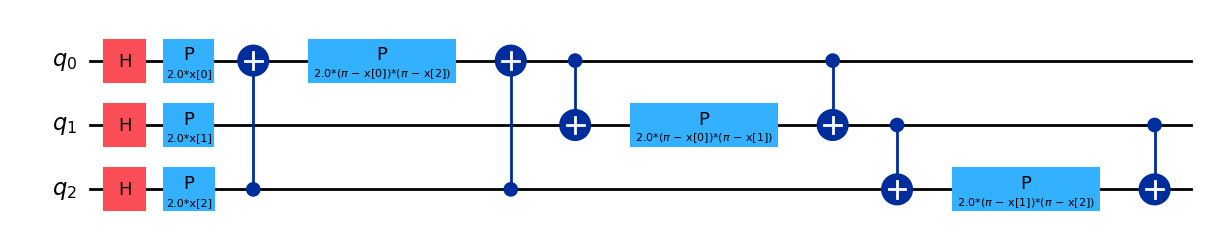

In [4]:
#feature_map = ZFeatureMap(feature_dimension=feature_dim, reps=1)
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=1, entanglement='circular')
feature_map.decompose().draw('mpl')

### State Transformation with Variational Form

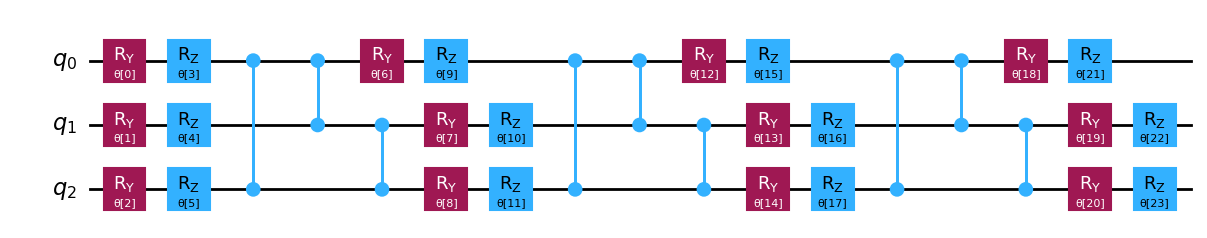

In [5]:
ansatz = TwoLocal(num_qubits=feature_dim, rotation_blocks=['ry', 'rz'], entanglement_blocks='cz', entanglement='circular', reps=3)
#ansatz = TwoLocal(num_qubits=feature_dim, rotation_blocks=['ry'], entanglement_blocks='cz', entanglement='circular', reps=3)
ansatz.decompose().draw('mpl')

### Measurement and Model Output

In [6]:
# Use Sampler instead of backend
sampler = Sampler()

# When using quantum hardware
# instance = 'ibm-q/open/main'

# try:
#     service = QiskitRuntimeService(channel='ibm_quantum', instance=instance)
# except AccountNotFoundError:
#     service = QiskitRuntimeService(channel='ibm_quantum', token='__paste_your_token_here__',
#                                    instance=instance)

# backend_name = 'ibm_washington'
# session = Session(service=service, backend=backend_name)

# sampler = RuntimeSampler(session=session)

maxiter = 300

optimizer = COBYLA(maxiter=maxiter, disp=True)

objective_func_vals = []
# Draw the value of objective function every time when the fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    #print('obj_func_eval =',obj_func_eval)

    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(objective_func_vals)
    plt.show()

vqc = VQC(num_qubits=feature_dim,
          feature_map=feature_map,
          ansatz=ansatz,
          loss="cross_entropy",
          optimizer=optimizer,
          callback=callback_graph,
          sampler=sampler)

/var/folders/wg/l7y2frtd5m7f_2r2sh2lmj800000gn/T/ipykernel_49769/3457193789.py:2: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


### Execute with Simulator

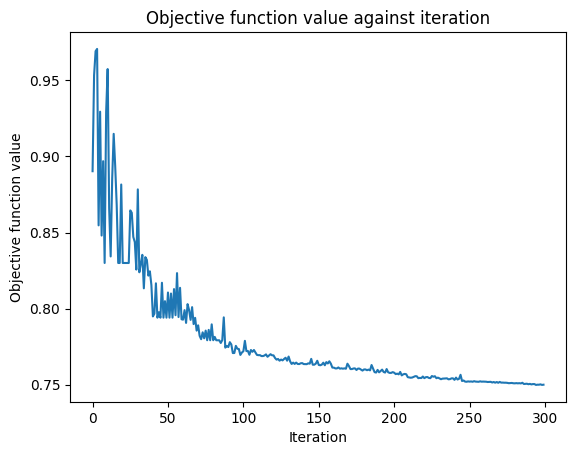


   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =  300   F = 7.498312E-01    MAXCV = 0.000000E+00
   X =-1.584785E-01  -1.168548E-01   6.069543E-01   1.231558E+00  -6.136579E-01
       1.543111E+00   6.926187E-01   1.665662E+00   4.210855E-01   5.063439E-01
       3.447320E-02   3.019993E-02   1.555306E+00   5.528412E-01   3.495150E-02
       7.006616E-01  -1.445381E-01   2.464535E-01   9.523036E-02   5.027012E-01
       4.592050E-01   5.682002E-01  -1.682257E-02   3.251892E-01
--- Classification Train score: 0.775 ---
--- Classification Test score:  0.5 ---


In [7]:
vqc.fit(norm_train_data, train_label_one_hot)

train_score = vqc.score(norm_train_data, train_label_one_hot)
test_score = vqc.score(norm_test_data, test_label_one_hot)

print(f'--- Classification Train score: {train_score} ---')
print(f'--- Classification Test score:  {test_score} ---')

## Event Classfication using Quantum Kernel Method

Now we try to tackle the same problme with quantum kernel method. First, implement a quantum circuit to encode input data as QuantumCircuit instance. You could use, e.g, ZFeatureMap or ZZFeatureMap as used above or something different.

You can change the number of qubits used, but it appears that FidelityQuantumKernel class that we use later will work better if the number of input features is the same as the number of qubits.

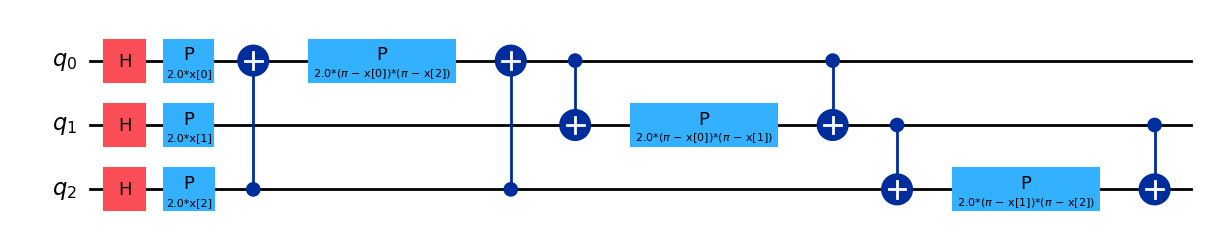

In [8]:
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=1, entanglement='circular')
feature_map.decompose().draw('mpl')

Next step is to create a quantum circuit to calculate kernel matrix from the feature map defined above. Qiskit has an API (FidelityQuantumKernel class) to do that, and we use it here.

In [9]:
# FidelityQuantumKernel creates a Sampler instance internally
q_kernel = FidelityQuantumKernel(feature_map=feature_map)

We try to calculate the fidelity between the two inputs states, $|\langle0^{\otimes n}|U_{\rm{in}}^\dagger(x_1)U_{\rm{in}}(x_0)|0^{\otimes n}\rangle|^2$, with the FidelityQuantumKernel class. The circuit to do that is obtained by assigning input data to parameters in the feature_map.

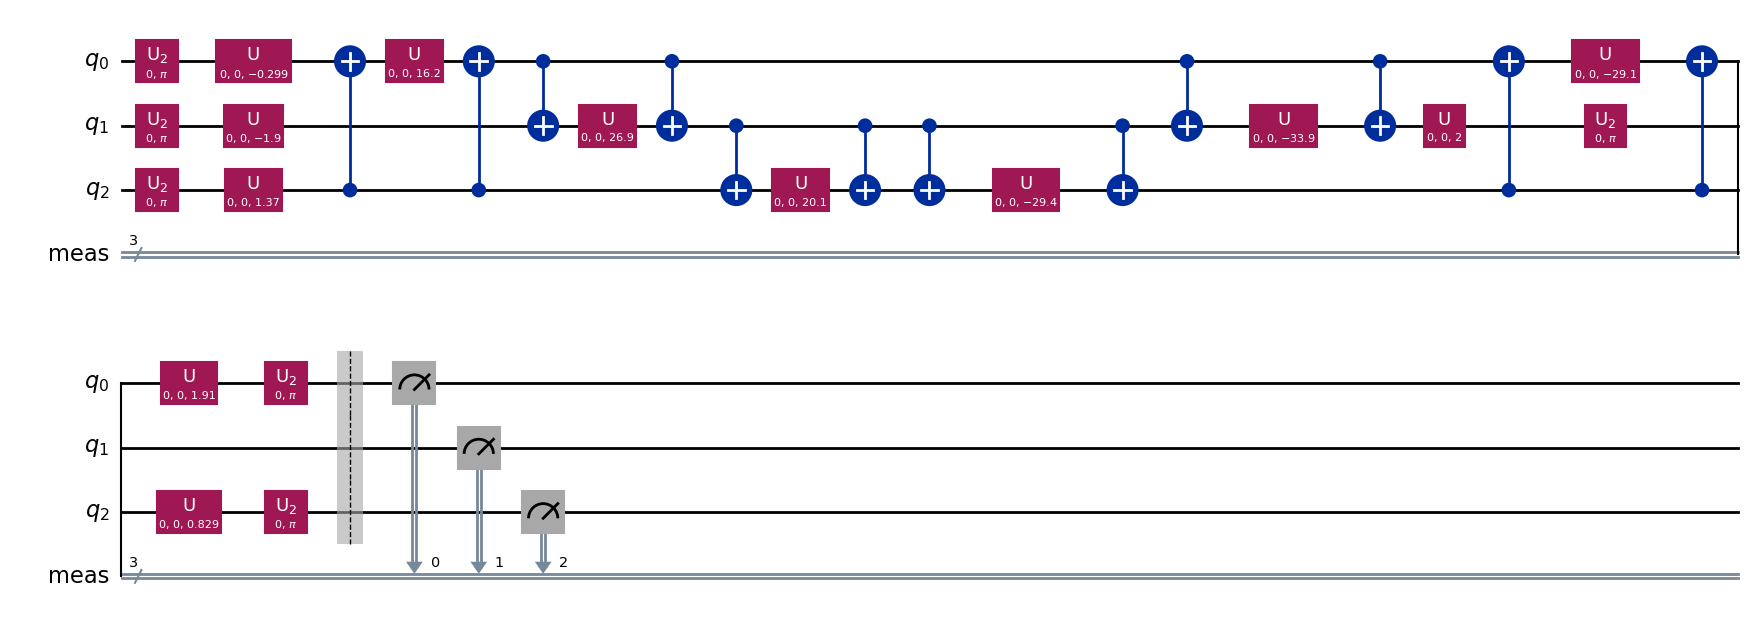

In [10]:
bind_params = dict(zip(feature_map.parameters, norm_train_data[0]))
feature_map_0 = feature_map.assign_parameters(bind_params)
bind_params = dict(zip(feature_map.parameters, norm_train_data[1]))
feature_map_1 = feature_map.assign_parameters(bind_params)

qc_circuit = q_kernel.fidelity.create_fidelity_circuit(feature_map_0, feature_map_1)
qc_circuit.decompose().decompose().draw('mpl')

Execute the circuit with simulator and calculate the probability of measuring 0 in all qubits after applying $U_{\rm{in}}^\dagger(x_1)U_{\rm{in}}(x_0)$ to the input $|0^{\otimes n}\rangle$ state.

In [11]:
sampler = Sampler()

job = sampler.run(qc_circuit, shots=10000)

# quasi_dists[0] is the probability distribution of expected measured counts
fidelity = job.result().quasi_dists[0].get(0, 0.)
print(f'|<φ(x_1)|φ(x_0)>|^2 = {fidelity}')

|<φ(x_1)|φ(x_0)>|^2 = 0.0614


/var/folders/wg/l7y2frtd5m7f_2r2sh2lmj800000gn/T/ipykernel_49769/3833464218.py:1: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


The FidelityQuantumKernel allows us to visualize a kernel matrix obtained from the fidelity calculations. Here we make plots of the kernel matrices calculated from the training data alone, and from the training and test data.


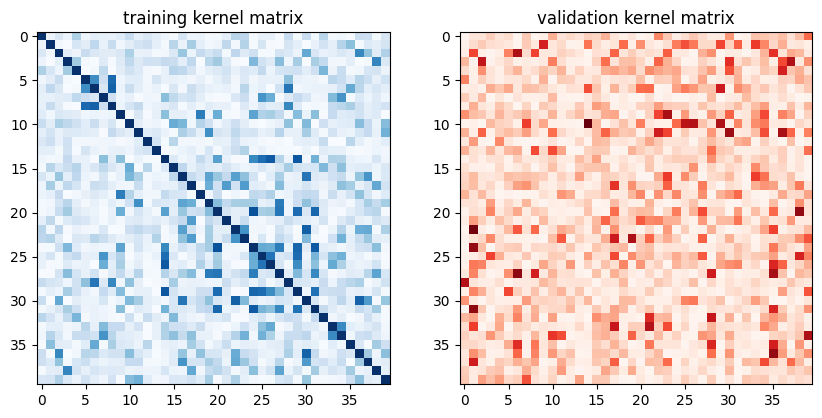

In [12]:
matrix_train = q_kernel.evaluate(x_vec=norm_train_data)
matrix_test = q_kernel.evaluate(x_vec=norm_test_data, y_vec=norm_train_data)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train), interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test), interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("validation kernel matrix")
plt.show()

Finally, the data are classified into signal and background using support vector machine implemented in sklearn package.

In [13]:
qc_svc = SVC(kernel='precomputed') # Default value of hyperparameter (C) is 1
qc_svc.fit(matrix_train, train_label)

train_score = qc_svc.score(matrix_train, train_label)
test_score = qc_svc.score(matrix_test, test_label)

print(f'Precomputed kernel: Classification Train score: {train_score*100}%')
print(f'Precomputed kernel: Classification Test score:  {test_score*100}%')

Precomputed kernel: Classification Train score: 87.5%
Precomputed kernel: Classification Test score:  32.5%


## Quantum Machine Learning on Quantum Data

We have considered so far a classical ML task with input classical data. Next, we consider a bit more *quantum* ML task, in which quantum computer could be more advantageous than classical computer in the future.

What we aim here is a *Hamiltonian learning* task of estimating classical parameters of a given Hamiltonian from quantum states generated under the Hamiltonian. The transverse-field Ising model is considered, and the tasks is to estimate the strength of transverse field by learning VQE-generated ground states using quantum neural networks.

Let's begin VQE using the Ising-model Hamiltonian with varied transverse-field strengths.

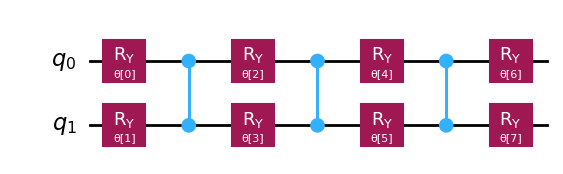

In [14]:
from qiskit_algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal

# VQE setup
num_qubits = 2

ansatz = TwoLocal(num_qubits, "ry", "cz", reps=3)  # Ry gates with trainable parameters and CZ for entanglement
optimizer = SLSQP(maxiter=1000)  # Classical optimizer
ansatz.decompose().draw('mpl')

The Ising model we consider has a parameter `alpha` that controls the mixture of transverse and longitudinal fields. `alpha=0` corresponds to a pure transverse field and `alpha=pi/2` a pure longitudinal field.

In [15]:
# Use Estimator
estimator = Estimator()
vqe = VQE(estimator, ansatz, optimizer)

# Ising model Hamiltonian with transverse and longitudinal fields
def get_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * np.sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * np.cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

# Example:
J = 0.2
h = 1.2
alpha = np.pi/8
H = get_hamiltonian(L=num_qubits, J=J, h=h, alpha=alpha)

result = vqe.compute_minimum_eigenvalue(H)
#print(result)
print(f'VQE energy value = {result.optimal_value:.5f}')

VQE energy value = -2.43940


/var/folders/wg/l7y2frtd5m7f_2r2sh2lmj800000gn/T/ipykernel_49769/2736377386.py:2: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


Since the system is small, the exact ground state energy can be calcualted by diagonalizing the Hamiltonian.

In [16]:
numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=H)
ref_value = result.eigenvalue.real
print(f"Reference energy value = {ref_value:.5f}")

Reference energy value = -2.43940


OK, now create a dataset of VQE ground states with different `h` values. For simplicity, the `alpha` parameter is set to 0 and only the transverse field is present.

In [17]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.circuit.library import RealAmplitudes
from qiskit_machine_learning.algorithms import NeuralNetworkRegressor

Nexp = 10   # number of experiments
Ntrain = 20  # number of training data per experiment
Ntest = 5
J = 0.2
alpha = 0

h_list = [np.random.rand()*0.25 for _ in range(Ntrain)]
#h_list = [np.random.rand() for _ in range(Ntrain)]
print(f'Input field strenghs = {h_list}')

Input field strenghs = [0.02228990542704523, 0.12171316265803675, 0.03190691171759252, 0.03056956410297973, 0.03336607080460652, 0.16155854328769742, 0.23317601694098344, 0.16408247233154877, 0.16067426040741395, 0.006100986539952613, 0.1764684401250579, 0.15671147360555882, 0.027096586987047172, 0.09598625710125047, 0.23577624819318016, 0.2084586611746604, 0.12242466791815684, 0.02224083519730466, 0.24102007261202305, 0.002951196073390727]


In [18]:
vqe_ansatz = TwoLocal(num_qubits, "ry", "cz", parameter_prefix='x')
optimizer = SLSQP(maxiter=1000)

estimator = Estimator()
vqe = VQE(estimator, vqe_ansatz, optimizer)

opt_vqe_energy = []
opt_vqe_params = []
for i in range(Ntrain):
    H = get_hamiltonian(L=num_qubits, J=J, h=h_list[i], alpha=alpha)
    result_vqe = vqe.compute_minimum_eigenvalue(H)
    opt_vqe_energy.append(result_vqe.optimal_value)
    opt_vqe_params.append(list(result_vqe.optimal_parameters.values()))
    print('VQE i =',i)

for i in range(Ntrain):
    print(f'VQE[{i}] energy value = {opt_vqe_energy[i]:.5f}')

/var/folders/wg/l7y2frtd5m7f_2r2sh2lmj800000gn/T/ipykernel_49769/2057885861.py:4: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


VQE i = 0
VQE i = 1
VQE i = 2
VQE i = 3
VQE i = 4
VQE i = 5
VQE i = 6
VQE i = 7
VQE i = 8
VQE i = 9
VQE i = 10
VQE i = 11
VQE i = 12
VQE i = 13
VQE i = 14
VQE i = 15
VQE i = 16
VQE i = 17
VQE i = 18
VQE i = 19
VQE[0] energy value = -0.20491
VQE[1] energy value = -0.31505
VQE[2] energy value = -0.20993
VQE[3] energy value = -0.20914
VQE[4] energy value = -0.21083
VQE[5] energy value = -0.38001
VQE[6] energy value = -0.50743
VQE[7] energy value = -0.38431
VQE[8] energy value = -0.37850
VQE[9] energy value = -0.20000
VQE[10] energy value = -0.40567
VQE[11] energy value = -0.37180
VQE[12] energy value = -0.20721
VQE[13] energy value = -0.27722
VQE[14] energy value = -0.51221
VQE[15] energy value = -0.46241
VQE[16] energy value = -0.31615
VQE[17] energy value = -0.20489
VQE[18] energy value = -0.52188
VQE[19] energy value = -0.20009


Sanity check with exact diagonalizatiion

In [19]:
numpy_solver = NumPyMinimumEigensolver()
for i in range(Ntrain):
    H = get_hamiltonian(L=num_qubits, J=J, h=h_list[i], alpha=alpha)
    result = numpy_solver.compute_minimum_eigenvalue(operator=H)
    ref_value = result.eigenvalue.real
    print(f"Reference[{i}] energy value = {ref_value:.5f}")

Reference[0] energy value = -0.20491
Reference[1] energy value = -0.31505
Reference[2] energy value = -0.20993
Reference[3] energy value = -0.20914
Reference[4] energy value = -0.21084
Reference[5] energy value = -0.38001
Reference[6] energy value = -0.50743
Reference[7] energy value = -0.38431
Reference[8] energy value = -0.37850
Reference[9] energy value = -0.20037
Reference[10] energy value = -0.40567
Reference[11] energy value = -0.37180
Reference[12] energy value = -0.20721
Reference[13] energy value = -0.27722
Reference[14] energy value = -0.51221
Reference[15] energy value = -0.46241
Reference[16] energy value = -0.31615
Reference[17] energy value = -0.20489
Reference[18] energy value = -0.52188
Reference[19] energy value = -0.20009


Now construct a quantum circuit with the optimized VQE circuit for generating ground states at the beginning and a QNN ansatz for learning the state at the end.

In [20]:
from qiskit_machine_learning.circuit.library import QNNCircuit

# Observable : Pauli Z for the first qubit
pauli = 'I' * (num_qubits - 1)
pauli += 'Z'
obs = SparsePauliOp([pauli],coeffs=2.)

# Callback function to store loss values
def callback_graph(weights, obj_func_eval):
    objective_func_vals.append(obj_func_eval)

# QNN setup with RealAmplitudes ansatz
nlayer = 3  # number of CX-RY layers

result_exp = []
regressor_exp = []
objective_func_vals_exp = []

# Repeat Nexp times
for iexp in range(Nexp):

    qnn_ansatz = RealAmplitudes(num_qubits=num_qubits, reps=nlayer, parameter_prefix='theta')

    '''
    qnn_ansatz = QuantumCircuit(num_qubits)
    theta = ParameterVector('theta')
    def new_theta():
        theta.resize(len(theta) + 1)
        return theta[-1]
    for il in range(0, nlayer):
        for i in range(0, num_qubits-1):
            qnn_ansatz.rzz(new_theta(),i,i+1)
        for i in range(0, num_qubits):
            qnn_ansatz.rx(new_theta(),i)
    '''

    qc = QuantumCircuit(num_qubits)
    qc.compose(vqe_ansatz, inplace=True)
    qc.compose(qnn_ansatz, inplace=True)

    # Random initial parameters within [0, pi]
    initial_weights = np.random.rand((nlayer+1)*num_qubits)*np.pi
    #initial_weights = np.random.rand((2*num_qubits-1)*nlayer)*np.pi

    # Use EstimatorQNN class
    qnn = EstimatorQNN(
        circuit = qc,
        input_params = vqe_ansatz.parameters,
        weight_params = qnn_ansatz.parameters,
        observables = obs
    )

    # Use NeuralNetworkRegressor for regression task with COBYLA optimizer
    regressor = NeuralNetworkRegressor(
        neural_network = qnn,
        loss = "squared_error",
        optimizer = SLSQP(maxiter=1000),
        warm_start = True,
        initial_point = initial_weights,
        callback = callback_graph
    )

    objective_func_vals = []
    result_regres = regressor.fit(np.array(opt_vqe_params),np.array(h_list))
    result_exp.append(result_regres)
    regressor_exp.append(regressor)
    objective_func_vals_exp.append(objective_func_vals)

    print(f'iexp = {iexp}')

/var/folders/wg/l7y2frtd5m7f_2r2sh2lmj800000gn/T/ipykernel_49769/1882718419.py:46: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(
/var/folders/wg/l7y2frtd5m7f_2r2sh2lmj800000gn/T/ipykernel_49769/1882718419.py:46: UserWarning: No number of qubits was not specified (None) and was retrieved from `circuit` (2). If `circuit` is transpiled, this may cause unstable behaviour.
  qnn = EstimatorQNN(


iexp = 0
iexp = 1
iexp = 2
iexp = 3
iexp = 4
iexp = 5
iexp = 6
iexp = 7
iexp = 8
iexp = 9


Make the plot of loss function values.

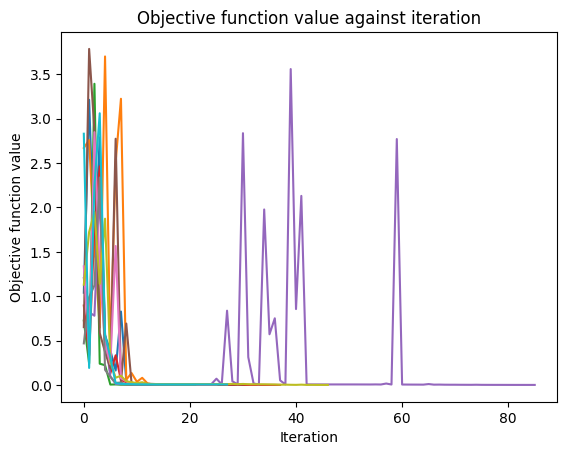

In [21]:
fig = plt.figure(facecolor="w")
ax = fig.add_subplot(1, 1, 1)
plt.title('Objective function value against iteration')
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
for iexp in range(Nexp):
    plt.plot(range(len(objective_func_vals_exp[iexp])), objective_func_vals_exp[iexp])
#plt.legend()
plt.show()

See the correlation between the true and predicted transverse-field strengths from the optimized QNN model. The plot shows only the training data.

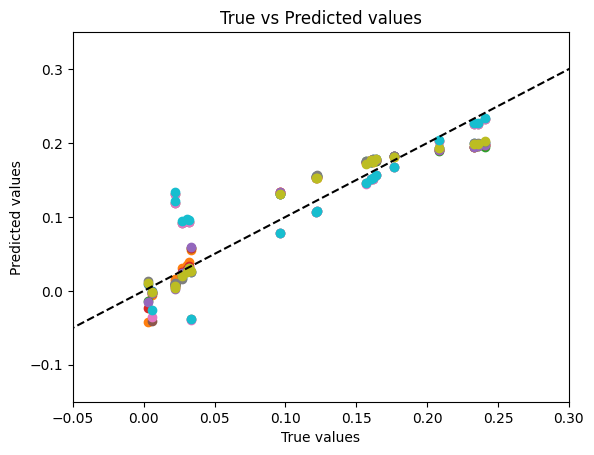

In [22]:
train_pred_exp = []
for iexp in range(Nexp):
    train_pred = regressor_exp[iexp].predict(np.array(opt_vqe_params))
    train_pred_exp.append(train_pred)
    plt.scatter(h_list, train_pred, label='training')
plt.title('True vs Predicted values')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.xlim(-0.05,0.3)
plt.ylim(-0.15,0.35)
plt.plot([-0.2,1.2],[-0.2,1.2],'k--')
plt.show()